In [1]:
import sys
import gc

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier 


c:\Users\dasha\anaconda3\envs\text\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
df = pd.read_csv('labelled_train_set.csv')
print(f"Original shape {df.shape}")
df = df.drop_duplicates(subset=['Article'])
df.reset_index(drop=True, inplace=True)
print(f"Updated shape {df.shape}")

Original shape (500, 3)
Updated shape (499, 3)


In [3]:
df.Type.value_counts()

Type
Human-written    385
AI-generated     114
Name: count, dtype: int64

In [4]:
df.tail()

,ID,Article,Type
494,TRAIN_496,Handwriting recognition technology has numerou...,AI-generated
495,TRAIN_497,Digital Rights Management (DRM) (sometimes als...,Human-written
496,TRAIN_498,A cookie is a small piece of data that is stor...,AI-generated
497,TRAIN_499,The hexadecimal system is a number system with...,AI-generated
498,TRAIN_500,Secure Hash A process which reduces a message ...,Human-written


In [5]:
class2idx = {"Human-written": 0, "AI-generated": 1}
df['target'] = df['Type'].map(class2idx)

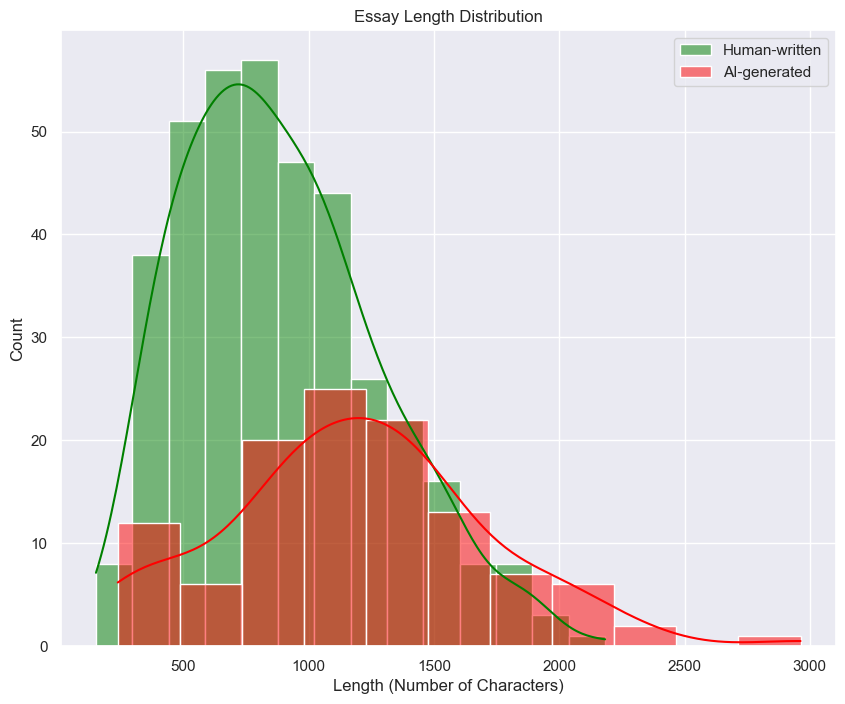

In [6]:
df['essay_length'] = df['Article'].apply(len)

sns.set(style="darkgrid")
plt.figure(figsize=(10, 8))

sns.histplot(df[df['target'] == 0]['essay_length'], color='green', label='Human-written', kde=True)

sns.histplot(df[df['target'] == 1]['essay_length'], color='red', label='AI-generated', kde=True)

plt.title("Essay Length Distribution")
plt.xlabel("Length (Number of Characters)")
plt.ylabel("Count")
plt.legend()
plt.show()

In [7]:
def calculate_text_metrics_simple(text:str):
    words = text.split()
    sentences = text.split('.')
    words = [word[:-1] for word in words if word.endswith(('.', '!', '?', ':'))]
    word_count = len(words)
    unique_word_count = len(set(words))
    sent_count = len(sentences)
    avg_word_len = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sent_count, avg_word_len

df['metrices'] = df['Article'].apply(calculate_text_metrics_simple)
df[['word_count', 'unique_word_count', 'sent_count', 'avg_word_len']] = pd.DataFrame(df['metrices'].tolist(), index=df.index)

df.drop('metrices', axis=1, inplace=True)
comparison_metrices = df.groupby('target')[['word_count', 'unique_word_count', 'sent_count', 'avg_word_len']].mean(
    numeric_only=True
)
comparison_metrices

,word_count,unique_word_count,sent_count,avg_word_len
target,,,,
0,6.529870,6.015584,7.251948,6.328425
1,10.350877,8.991228,9.614035,7.501476


In [8]:
test = df.sample(frac=0.2, random_state=42)
abt = df.drop(test.index)

abt.shape, test.shape

((399, 9), (100, 9))

In [9]:
LOWERCASE = True
VOCAB_SIZE = 30000

In [10]:
raw_tokenizer = Tokenizer(models.BPE(unk_token='[UNK]'))

raw_tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else []
    )
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

special_tokens = ['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]']
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

dataset = Dataset.from_pandas(abt[['Article']])

def train_crop_iter():
    for article in tqdm(dataset['Article']):
        yield article

raw_tokenizer.train_from_iterator(train_crop_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token='[UNK]',
    pad_token='[PAD]',
    cls_token='[CLS]',
    sep_token='[SEP]',
    mask_token='[MASK]',
)

tokenized_texts_test = []
for article in tqdm(test['Article']):
    tokenized_texts_test.append(tokenizer.tokenize(article))
    
tokenized_texts_train = []
for article in tqdm(abt['Article']):
    tokenized_texts_train.append(tokenizer.tokenize(article))

100%|██████████| 399/399 [00:00<00:00, 757.67it/s]


In [11]:
tokenized_texts_test[3][:10]

['Ġweb',
 'Ġservices',
 'Ġcan',
 'Ġbe',
 'Ġaccessed',
 'Ġusing',
 'Ġa',
 'Ġvariety',
 'Ġof',
 'Ġprotocols']

In [12]:
def dummy(text):
    return text

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5),
                             lowercase=False,
                             sublinear_tf=True,
                             analyzer='word',
                             tokenizer=dummy,
                             preprocessor=dummy,
                             token_pattern=None,
                             strip_accents='unicode')

# fitting tie tokenizer on test set
vectorizer.fit(tokenized_texts_test)
vocab = vectorizer.vocabulary_

# print(vocab)

# fitting it in train set
vectorizer.fit(tokenized_texts_train)
vocab = vectorizer.vocabulary_

# print(vocab)

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

107

In [14]:
y_train = abt['target'].values
y_train[:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [15]:
tf_train

<399x191178 sparse matrix of type '<class 'numpy.float64'>'
	with 202501 stored elements in Compressed Sparse Row format>

In [16]:
tf_train.shape, tf_test.shape

((399, 191178), (100, 191178))

In [17]:
bayes_model = MultinomialNB(alpha=0.03)
sgd_model = SGDClassifier(max_iter=6000, tol=1e-3, loss='modified_huber')

ensemble = VotingClassifier(estimators=[('sgd', sgd_model), ('bayes', bayes_model)],
                            weights=[0.7, 0.3],
                            voting='soft')
ensemble.fit(tf_train, y_train)

gc.collect()

4668

In [18]:
test_preds = ensemble.predict(tf_test)
test_preds

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)

In [19]:
def score(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1: {f1_score(y_true, y_pred):.3f}")
    print()
    print(classification_report(y_true, y_pred))
    print()
    print(confusion_matrix(y_true, y_pred))

In [20]:
score(test['target'].values, test_preds)

Accuracy: 0.980
Precision: 1.000
Recall: 0.913
F1: 0.955

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        77
           1       1.00      0.91      0.95        23

    accuracy                           0.98       100
   macro avg       0.99      0.96      0.97       100
weighted avg       0.98      0.98      0.98       100


[[77  0]
 [ 2 21]]


In [21]:
import pickle 

with open('model_a980f955.pkl', 'wb') as f:
    pickle.dump(ensemble, f)